In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import datetime
# xlrd is required for reading xls Excel files
import xlrd
import re
import sqlite3
import meteostat as mt
# Use this when displaying markdown in Jupyter Notebooks ( Gemini suggestion )
from IPython.display import display, Markdown
# do AdaBoost regression to predict PV(W) from the other columns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Determine the current path of the notebook
notebook_path = os.path.abspath("big_project.ipynb")
notebook_dir = os.path.dirname(notebook_path).replace('\\', '/')
print("Current notebook directory:", notebook_dir)
HOME_DIR = f'{notebook_dir}'
DATA_DIR = f'{HOME_DIR}/data/'
print("Data directory set to:", DATA_DIR)
RAW_DATA_DIR = f'{DATA_DIR}/raw_data/'
TRAIN_DATA_DIR = f'{DATA_DIR}/training_data/'
SQL_DB_PATH = f'{DATA_DIR}/db_sqlite/'
SQL_DB_FILE = f'{SQL_DB_PATH}/big_project_db.sqlite3'
BACKUP_FILE_TYPE = 'feather'  # Options: 'csv', 'feather', 'parquet'
# Plotly setup
plt.style.use('classic')
sns.set_style('whitegrid')
# Meteostat setup
METEOSTAT_CACHE_DIR = f'{DATA_DIR}/meteostat_cache/'
SOLAR_SITE_POSITION = (53.6985, -6.2080)  # Bettystown, Ireland
LATITUDE, LONGITUDE = SOLAR_SITE_POSITION
WEATHER_START_DATE = datetime.datetime(2024, 1, 1)
WEATHER_END_DATE = datetime.datetime.now()
# Solar panel configuration 
# Determined this using gemini and google maps measurements
ROOF_PANE_I_ANGLE = 30  # degrees
ROOF_PANE_II_ANGLE = 30  # degrees
ROOF_PANE_I_AZIMUTH = 65  # degrees ( East-South-East)
ROOF_PANE_II_AZIMUTH = 245  # degrees ( West-South-West)
ROOF_PANE_I_COUNT = 7
ROOF_PANE_II_COUNT = 12
SOLAR_PANEL_POWER_RATING_W = 440  # Watts per panel
TOTAL_SOLAR_PANE_I_CAPACITY_W = ROOF_PANE_I_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_PANE_II_CAPACITY_W = ROOF_PANE_II_COUNT * SOLAR_PANEL_POWER_RATING_W
TOTAL_SOLAR_CAPACITY_W = TOTAL_SOLAR_PANE_I_CAPACITY_W + TOTAL_SOLAR_PANE_II_CAPACITY_W

Current notebook directory: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project
Data directory set to: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data/


In [3]:
hourly_nightly_threshold = 50

# AdaBoost Regression Analysis Of Solar and Weather

[AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html)

In [4]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [5]:
file_enriched_features = "data/processed_data/hourly_solar_copernicus_enriched_data.feather"
file_weather_data = "data/processed_data/hourly_weather_data.feather"
file_solar_data="data/processed_data/daily_solar_data.feather"
file_training_data = f"{TRAIN_DATA_DIR}/hourly_solar_training_data.feather"
file_testing_data = f"{TRAIN_DATA_DIR}/hourly_solar_testing_data.feather"


__Load Test and Training Data_


In [6]:
df_daytime_train = pd.read_feather(f"{TRAIN_DATA_DIR}/hourly_solar_training_data.feather")
df_daytime_test = pd.read_feather(f"{TRAIN_DATA_DIR}/hourly_solar_testing_data.feather")

# use list comprehension to get list of columns for level 1 and level 2 from weather data
# level 1 and levl 2 are based on condition codes from meteostat - it onehot encoding of weather conditions , with level 1 lowest level , and level 2 a summary level
level1_features = [level for level in df_daytime_train.columns.tolist() if level.startswith('level1_')]
level2_features = [level for level in df_daytime_train.columns.tolist() if level.startswith('level2_')]

In [7]:
# display column list and data types and index
display(pd.DataFrame({"Columns": df_daytime_train.columns, "Data Types": df_daytime_train.dtypes}))


,Columns,Data Types
index,index,int64
DateTime,DateTime,datetime64[ns]
PV(W),PV(W),float64
Temperature(C),Temperature(C),Float64
Humidity(%),Humidity(%),Float64
...,...,...
Hour,Hour,int32
Clearsky_Index,Clearsky_Index,float64
PV(W)_error,PV(W)_error,float64
PV(W)_error_index,PV(W)_error_index,float64


## Histogram of various solar measures 

This shows a histogram of the various measures solar output. 

In [8]:

feature_cols = []
# Columns: ['index', 'DateTime', 'PV(W)', 'Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Condition Code', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Wind Gust(m/s)', 'Pressure(hPa)', 'Snow Depth(cm)', 'level1_clear', 'level1_cloudy', 'level1_fair', 'level1_fog', 'level1_freezing_rain', 'level1_heavy_rain', 'level1_heavy_rain_shower', 'level1_heavy_sleet', 'level1_light_rain', 'level1_overcast', 'level1_rain', 'level1_rain_shower', 'level1_sleet', 'level1_sleet_shower', 'level1_thunderstorm', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather', '# Observation period', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'Clear sky BNI', 'GHI', 'BHI', 'DHI', 'BNI', 'Reliability,', 'Time', 'Date', 'POA_Pane_I(W/m^2)', 'POA_Pane_II(W/m^2)', 'POAC_Pane_I(W/m^2)', 'POAC_Pane_II(W/m^2)', 'Power_Pane_I(W)', 'Power_Pane_II(W)', 'Power_ClearSky_Pane_I(W)', 'Power_ClearSky_Pane_II(W)', 'Total_Power_Output(W)', 'Total_Power_ClearSky_Output(W)', 'WeekOfYear', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin']
feature_cols = []
test_no="999"
# Define target column

#target_col = 'PV(W)'
#target_col = 'Clearsky_Index'
target_col = 'PV(W)_error'
#target_col = 'PV(W)_error_index'
#
test_name=f"Optimal Features  No Level 2 and No Clearsky - Target {target_col}"
notes="This is the best combination of features exclude level 2 and no clearsky weather features"

# Put change here to add more features
feature_cols.append('Temperature(C)')
feature_cols.append('Humidity(%)')
feature_cols.append('Sunshine Duration')
#feature_cols.append('Condition Code')
feature_cols.append('Precipitation(mm)')
feature_cols.append('Dew Point(C)')
feature_cols.append('Wind Direction(deg)')
feature_cols.append('Wind Speed(m/s)')
#feature_cols.append('Wind Gust(m/s)')
feature_cols.append('Pressure(hPa)')
#feature_cols.append('Snow Depth(cm)')
feature_cols.append('Wind Cooling')
#  level1_features
#feature_cols.append('# Observation period')
#feature_cols.append('TOA')
#feature_cols.append('Clear sky GHI')
#feature_cols.append('Clear sky BHI')
#feature_cols.append('Clear sky DHI')
#feature_cols.append('Clear sky BNI')
# Relate to target #feature_cols.append('GHI')
# Relate to target #feature_cols.append('BHI')
# Relate to target #feature_cols.append('DHI')
# Relate to target #feature_cols.append('BNI')
# String ignore feature_cols.append('Reliability,')
# Relate to target #feature_cols.append('POA_Pane_I(W/m^2)')
# Relate to target #feature_cols.append('POA_Pane_II(W/m^2)')
# Relate to target #feature_cols.append('POAC_Pane_I(W/m^2)')
# Relate to target #feature_cols.append('POAC_Pane_II(W/m^2)')
# Relate to target #feature_cols.append('Power_Pane_I(W)')
# Relate to target #feature_cols.append('Power_Pane_II(W)')
#feature_cols.append('Power_ClearSky_Pane_I(W)')
#feature_cols.append('Power_ClearSky_Pane_II(W)')
# Relate to target #feature_cols.append('Total_Power_Output(W)')
feature_cols.append('Total_Power_ClearSky_Output(W)')
#feature_cols.append('WeekOfYear')
feature_cols.append('Month_Sin')
feature_cols.append('DayOfYear_Sin')
feature_cols.append('HourOfDay_Sin')
#  level2_features
feature_cols += level2_features
#  level1_features
#feature_cols += level1_features

print(f"\nTesting AdaBoost Regressor with target: {target_col} and features: {feature_cols}")



Testing AdaBoost Regressor with target: PV(W)_error and features: ['Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Pressure(hPa)', 'Wind Cooling', 'Total_Power_ClearSky_Output(W)', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather']


In [9]:

print(f"\nTesting AdaBoost Regressor with target: {target_col} and features: {feature_cols}")
# Create x and y for training and testing
X_train = df_daytime_train[feature_cols]
y_train = df_daytime_train[target_col]
X_test = df_daytime_test[feature_cols]
y_test = df_daytime_test[target_col]
# print shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
# Save test and training x and y to feather files
# This allows later analysis without needing to redo the train test split
X_train.to_pickle(f"{TRAIN_DATA_DIR}/X_train_test_no_{test_no}.pickle")
y_train.to_pickle(f"{TRAIN_DATA_DIR}/y_train_test_no_{test_no}.pickle")
X_test.to_pickle(f"{TRAIN_DATA_DIR}/X_test_test_no_{test_no}.pickle")
y_test.to_pickle(f"{TRAIN_DATA_DIR}/y_test_test_no_{test_no}.pickle")
# Also put test no , name and notes in a dataframe and save as feather
test_info_df = pd.DataFrame({
    "Test No": [test_no],
    "Test Name": [test_name],
    "Notes": [notes],
    'target_col': [target_col],
    'feature_cols': [feature_cols]
})
test_info_df.to_feather(f"{TRAIN_DATA_DIR}/test_info_test_no_{test_no}.pickle")



Testing AdaBoost Regressor with target: PV(W)_error and features: ['Temperature(C)', 'Humidity(%)', 'Sunshine Duration', 'Precipitation(mm)', 'Dew Point(C)', 'Wind Direction(deg)', 'Wind Speed(m/s)', 'Pressure(hPa)', 'Wind Cooling', 'Total_Power_ClearSky_Output(W)', 'Month_Sin', 'DayOfYear_Sin', 'HourOfDay_Sin', 'level2_good_visibility', 'level2_moderate_visibility', 'level2_poor_visibility', 'level2_precipitation', 'level2_severe_weather']
X_train shape: (2192, 18)
y_train shape: (2192,)
X_test shape: (2194, 18)
y_test shape: (2194,)


In [10]:
# Initialize AdaBoost Regressor with optimized hyperparameters
# Base estimator: Decision tree with limited depth to prevent overfitting
# n_estimators: Number of boosting iterations
# learning_rate: Weight applied to each regressor at each boosting iteration
base_estimator = DecisionTreeRegressor(max_depth=10, random_state=42)

ada_model = AdaBoostRegressor(
    estimator=base_estimator,
    n_estimators=500,
    learning_rate=0.1,
    random_state=42
)

# Train the model
ada_model.fit(X_train, y_train)

# Make predictions
y_pred_train = ada_model.predict(X_train)
y_pred_test = ada_model.predict(X_test)


__Metrics for Tests 

In [11]:
# generate 3 main metrics: RMSE, MAE, R2 for both training and testing
from sklearn.metrics import mean_absolute_error

# Calculate metrics for residuals (target_col)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)
train_n_rmse = train_rmse / y_train.mean()
train_n_mae = train_mae / y_train.mean()
train_accuracy = 1 - train_n_rmse

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)
test_n_rmse = test_rmse / y_test.mean()
test_n_mae = test_mae / y_test.mean()
test_accuracy = 1 - test_n_rmse

print(f"\nAdaBoost Model Results for {target_col}:")
print(f"Train RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}, R2: {train_r2:.4f}, N-RMSE: {train_n_rmse:.4f}, N-MAE: {train_n_mae:.4f}, Accuracy: {train_accuracy:.4f}")
print(f"Test  RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}, R2: {test_r2:.4f}, N-RMSE: {test_n_rmse:.4f}, N-MAE: {test_n_mae:.4f}, Accuracy: {test_accuracy:.4f}")

# Reconstruct actual PV(W) values for final evaluation
y_train_actual = y_train + df_daytime_train['Total_Power_ClearSky_Output(W)']
y_pred_train_actual = y_pred_train + df_daytime_train['Total_Power_ClearSky_Output(W)']
y_test_actual = y_test + df_daytime_test['Total_Power_ClearSky_Output(W)']
y_pred_test_actual = y_pred_test + df_daytime_test['Total_Power_ClearSky_Output(W)']

# Clip negative predictions to 0
y_pred_train_actual = y_pred_train_actual.clip(lower=0)
y_pred_test_actual = y_pred_test_actual.clip(lower=0)

# Calculate metrics for actual PV(W) predictions
train_rmse_pvw = np.sqrt(mean_squared_error(y_train_actual, y_pred_train_actual))
train_mae_pvw = mean_absolute_error(y_train_actual, y_pred_train_actual)
train_r2_pvw = r2_score(y_train_actual, y_pred_train_actual)
train_n_rmse_pvw = train_rmse_pvw / y_train_actual.mean()
train_n_mae_pvw = train_mae_pvw / y_train_actual.mean()
train_accuracy_pvw = 1 - train_n_rmse_pvw

test_rmse_pvw = np.sqrt(mean_squared_error(y_test_actual, y_pred_test_actual))
test_mae_pvw = mean_absolute_error(y_test_actual, y_pred_test_actual)
test_r2_pvw = r2_score(y_test_actual, y_pred_test_actual)
test_n_rmse_pvw = test_rmse_pvw / y_test_actual.mean()
test_n_mae_pvw = test_mae_pvw / y_test_actual.mean()
test_accuracy_pvw = 1 - test_n_rmse_pvw

print(f"\nAdaBoost Model Results for PV(W):")
print(f"Train RMSE: {train_rmse_pvw:.2f}, MAE: {train_mae_pvw:.2f}, R2: {train_r2_pvw:.4f}, N-RMSE: {train_n_rmse_pvw:.4f}, N-MAE: {train_n_mae_pvw:.4f}, Accuracy: {train_accuracy_pvw:.4f}")
print(f"Test  RMSE: {test_rmse_pvw:.2f}, MAE: {test_mae_pvw:.2f}, R2: {test_r2_pvw:.4f}, N-RMSE: {test_n_rmse_pvw:.4f}, N-MAE: {test_n_mae_pvw:.4f}, Accuracy: {test_accuracy_pvw:.4f}")



AdaBoost Model Results for PV(W)_error:
Train RMSE: 125.00, MAE: 91.17, R2: 0.9887, N-RMSE: -0.0823, N-MAE: -0.0600, Accuracy: 1.0823
Test  RMSE: 648.80, MAE: 460.06, R2: 0.6550, N-RMSE: -0.4609, N-MAE: -0.3268, Accuracy: 1.4609

AdaBoost Model Results for PV(W):
Train RMSE: 124.96, MAE: 91.13, R2: 0.9923, N-RMSE: 0.0707, N-MAE: 0.0516, Accuracy: 0.9293
Test  RMSE: 648.77, MAE: 459.99, R2: 0.7803, N-RMSE: 0.3405, N-MAE: 0.2414, Accuracy: 0.6595


In [12]:
# feature importance plot
importances = ada_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(20))


                           Feature  Importance
9   Total_Power_ClearSky_Output(W)    0.388504
2                Sunshine Duration    0.177116
7                    Pressure(hPa)    0.065537
1                      Humidity(%)    0.064997
11                   DayOfYear_Sin    0.048295
5              Wind Direction(deg)    0.046359
4                     Dew Point(C)    0.040154
8                     Wind Cooling    0.039909
0                   Temperature(C)    0.037637
12                   HourOfDay_Sin    0.033699
6                  Wind Speed(m/s)    0.017744
13          level2_good_visibility    0.015362
3                Precipitation(mm)    0.012712
10                       Month_Sin    0.005769
14      level2_moderate_visibility    0.003629
16            level2_precipitation    0.002576
15          level2_poor_visibility    0.000002
17           level2_severe_weather    0.000000



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



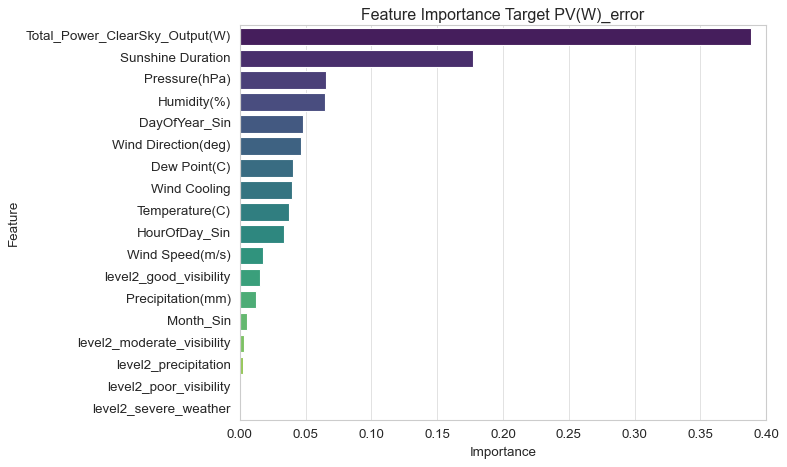

In [13]:

plt.figure(figsize=(10, 6))
plt.title(f'Feature Importance Target {target_col}')
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


NameError: name 'y_test_pred' is not defined

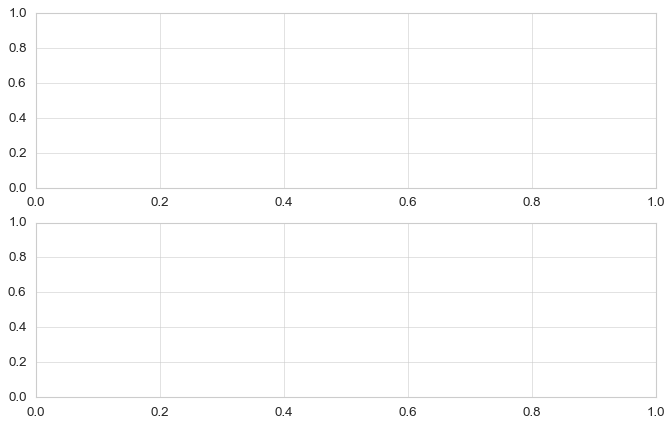

In [14]:
# plot residuals
#import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1,figsize=(10,6))
ax = ax.flatten()

# use sns scatter plot to show residuals
sns.set_style("whitegrid")
sns.scatterplot(x=y_test, y=y_test - y_test_pred, color='blue', label='Test Data', alpha=0.5 ,ax=ax[0])
sns.scatterplot(x=y_train, y=y_train - y_train_pred, color='green', label='Train Data', alpha=0.4, ax=ax[0])
ax[0].axhline(y=0, color='red', linestyle='--')
ax[0].set_title(f'Residuals vs Actual {target_col}')
ax[0].set_xlabel(f'Actual {target_col}')
ax[0].set_ylabel('Residuals (Actual - Predicted)')
ax[0].legend()

# use sns scatter plot to show residuals
sns.set_style("whitegrid")
sns.scatterplot(x=y_test_pvw, y=y_test_pvw - y_test_pvw_pred, color='blue', label='Test Data', alpha=0.5 ,ax=ax[1])
sns.scatterplot(x=y_train_pvw, y=y_train_pvw - y_train_pvw_pred, color='green', label='Train Data', alpha=0.4, ax=ax[1])
ax[1].axhline(y=0, color='red', linestyle='--')
ax[1].set_title(f'Residuals vs Actual PV(W)')
ax[1].set_xlabel(f'Actual PV(W)')
ax[1].set_ylabel('Residuals (Actual - Predicted)')
ax[1].legend()
plt.tight_layout()
plt.show()




In [ ]:
# plot risduals per hour of day
fig, ax = plt.subplots(2,1,figsize=(10,12))
ax = ax.flatten()
sns.scatterplot(x=df_daytime_test['DateTime'].dt.hour, y=y_test - y_test_pred, color='blue', label='Test Data', alpha=0.5,ax=ax[0])
sns.scatterplot(x=df_daytime_train['DateTime'].dt.hour, y=y_train - y_train_pred
, color='green', label='Train Data', alpha=0.4, ax=ax[0])
ax[0].axhline(y=0, color='red', linestyle='--')
ax[0].set_title('Residuals vs Hour of Day')
ax[0].set_xlabel('Hour of Day')
ax[0].set_ylabel('Residuals (Actual - Predicted)')
ax[0].legend()
sns.scatterplot(x=df_daytime_test['DateTime'].dt.hour, y=y_test_pvw - y_test_pvw_pred, color='blue', label='Test Data', alpha=0.5,ax=ax[1])
sns.scatterplot(x=df_daytime_train['DateTime'].dt.hour, y=y_train_pvw - y_train_pvw_pred
, color='green', label='Train Data', alpha=0.4, ax=ax[1])
ax[1].axhline(y=0, color='red', linestyle='--')
ax[1].set_title('Residuals vs Hour of Day')
ax[1].set_xlabel('Hour of Day')
ax[1].set_ylabel('Residuals (Actual - Predicted)')
ax[1].legend()
plt.show()

In [ ]:
# Residual histogram
def plot_residuals_histogram():
    # Keep the main fig and ax definition
    fig, ax = plt.subplots(2, 2, figsize=(18, 14)) # Slightly taller to prevent title overlap
    ax = ax.flatten()
    fig.suptitle('Residuals Analysis', fontsize=18)
    
    # Subplot 1: Histograms
    sns.histplot(y_test - y_test_pred, color='blue', label='Test Data', kde=True, bins=30, ax=ax[0])
    sns.histplot(y_train - y_train_pred, color='green', label='Train Data', kde=True, bins=30, ax=ax[0])
    ax[0].set_title('Residuals Histogram')
    ax[0].legend() # Added legend here so you can see which is which

    # Subplot 2: Density (Removed the extra plt.figure call)
    sns.kdeplot(y_test - y_test_pred, color='blue', label='Test Data', fill=True, ax=ax[1])
    sns.kdeplot(y_train - y_train_pred, color='green', label='Train Data', fill=True, ax=ax[1])
    ax[1].set_title('Residuals Density Plot')
    ax[1].set_xlabel('Residuals (Actual - Predicted)')
    ax[1].set_ylabel('Density')
    ax[1].legend()
    # plot difference of residuals between train and test as histogram
    sns.histplot((y_test - y_test_pred) - (y_train - y_train_pred), color='red', label='Test - Train Residuals', kde=True, stat="count", bins=30, ax=ax[2])
    ax[2].set_title('Difference of Residuals Histogram')
    ax[2].set_xlabel('Difference of Residuals')
    ax[2].set_ylabel('Frequency')
    ax[2].legend()

    # plot difference of residuals
    sns.kdeplot((y_test - y_test_pred) - (y_train - y_train_pred), color='red', label='Test - Train Residuals', fill=True, ax=ax[3])
    ax[3].set_title('Difference of Residuals Density Plot')
    ax[3].set_xlabel('Difference of Residuals')
    ax[3].set_ylabel('Density')
    ax[3].legend()
    plt.show()


plot_residuals_histogram()

### **🔬 Deep Dive: Spatiotemporal Error Analysis**

This section explores the specific conditions under which the AdaBoost model underperforms. By isolating the residuals in the **95th percentile** (extreme errors) and mapping them against temporal features, we uncover the model's "blind spots."

#### **1\. The "Error Loop" (Convex Hull Analysis)**

Visualizing the high-error grouping area reveals a distinct geometric pattern rather than random noise:

* **The Shape:** The errors form a loop structure when plotting *Hour of Day* vs. *Day of Year*. This shape closely mirrors the **Solar Analemma**—the figure-8 path the sun traces in the sky over a year.  
* **The "Hole" in the Center:** The absence of high errors in the center of the plot indicates that the model performs reliably during "stable" solar windows (e.g., mid-day in summer or stable winter low-light), where the relationship between time and irradiance is linear and predictable.  
* **The Boundary (The Danger Zone):** The model struggles most at the **edges** of the solar window:  
  * **Sunrise/Sunset Gradients:** Rapid changes in air mass and atmospheric scattering occur here.  
  * **Shoulder Seasons:** During Spring and Autumn equinoxes, weather volatility is higher, making static training data less representative of daily variance.

#### **2\. Metric Interpretation for Solar Forecasting**

| Metric | Value | Technical Context |
| :---- | :---- | :---- |
| **Testing R² (0.4787)** | Moderate | While the model captures the general day/night cycle well, the moderate R² on the test set suggests it misses high-frequency variance (e.g., passing clouds). This is typical for models lacking time-series memory (like LSTM) or cloud motion vectors. |
| **N-MAE (7.78%)** | Good | A Normalized Mean Absolute Error under 10% is generally considered deployment-ready for grid integration tasks. It means the average prediction error is less than 8% of the system's total capacity. |
| **RMSE vs. MAE** | Gap exists | The gap between RMSE (0.04) and MAE (0.03) indicates the presence of outliers. Since RMSE penalizes large errors more heavily, this confirms that while the model is generally accurate, it occasionally misses significantly (likely during the "Error Loop" times identified above). |

**Recommendation:** To improve performance in the identified "Error Loop," consider engineering features specifically for **Solar Elevation Angle** and **Azimuth**, or separating the model into "Clear Sky" vs. "Cloudy" sub-models.

In [ ]:
# Add QQ plot for residuals
import scipy.stats as stats
plt.figure(figsize=(10,6))
stats.probplot(y_test - y_test_pred, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals (Test Data)')
plt.show()


In [ ]:
# Plot actual vs predicted for first 200 samples
fig, ax = plt.subplots(4,1,figsize=(15, 18))
ax = ax.flatten()
if target_col == 'PV(W)':
    ax[0].plot(y_test[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[0].plot(y_test_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[0].set_title('AdaBoost: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[0].set_xlabel('Sample Index')
    ax[0].set_ylabel('Power Output (W)')
    ax[0].legend()
    # add a gap between test and train plots
    ax[1].plot(y_train[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[1].plot(y_train_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[1].set_title('AdaBoost: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[1].set_xlabel('Sample Index')
    ax[1].set_ylabel('Power Output (W)')
    ax[1].legend()
if target_col == 'Clearsky_Index':
    ax[0].plot(y_test[:200] *  df_daytime_test['Total_Power_ClearSky_Output(W)'][:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[0].plot(y_test_pred[:200] *  df_daytime_test['Total_Power_ClearSky_Output(W)'][:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[0].set_title('AdaBoost: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[0].set_xlabel('Sample Index')
    ax[0].set_ylabel('Power Output (W)')
    ax[0].legend()
    ax[1].plot(y_train[:200] *  df_daytime_train['Total_Power_ClearSky_Output(W)'][:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[1].plot(y_train_pred[:200] *  df_daytime_train['Total_Power_ClearSky_Output(W)'][:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[1].set_title('AdaBoost: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[1].set_xlabel('Sample Index')
    ax[1].set_ylabel('Power Output (W)')
    ax[1].legend()

    ax[2].plot(y_test[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[2].plot(y_test_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[2].set_title('AdaBoost: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[2].set_xlabel('Sample Index')
    ax[2].set_ylabel(target_col)
    ax[2].legend()

    ax[3].plot(y_train[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[3].plot(y_train_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[3].set_title('AdaBoost: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[3].set_xlabel('Sample Index')
    ax[3].set_ylabel(target_col)
    ax[3].legend()
if target_col == 'PV(W)_error' :
    ax[0].plot((y_test[:200]+ df_daytime_test['Total_Power_ClearSky_Output(W)'][:200]).clip(lower=0), label=f'Actual  Calculated PV(W) Clipped' , color='blue', alpha=0.7)
    ax[0].plot((y_test_pred[:200]+ df_daytime_test['Total_Power_ClearSky_Output(W)'][:200]).clip(lower=0), label='Predicted Calculated PV(W) Clipped', color='red', alpha=0.7)
    ax[0].plot(df_daytime_test['PV(W)'][:200], label='Actual PV(W)', color='green', linestyle=':', alpha=0.7)
    ax[0].set_title('AdaBoost: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[0].set_xlabel('Sample Index')
    ax[0].set_ylabel('Power Output (W)')
    ax[0].legend()
    ax[1].plot((y_train[:200] + df_daytime_train['Total_Power_ClearSky_Output(W)'][:200]).clip(lower=0), label=f'Actual Calculated PV(W)  Clipped', color='blue', alpha=0.7)
    ax[1].plot((y_train_pred[:200]+ df_daytime_train['Total_Power_ClearSky_Output(W)'][:200]).clip(lower=0), label='Predicted Calculated PV(W)  Clipped', color='red', linestyle='--', alpha=0.7)
    ax[1].set_title('AdaBoost: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[1].set_xlabel('Sample Index')
    ax[1].set_ylabel('Power Output (W)')
    ax[1].legend()
    ax[2].plot(y_test_pvw[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[2].plot(y_test_pvw_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[2].set_title('AdaBoost: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[2].set_xlabel('Sample Index')
    ax[2].set_ylabel(target_col)
    #ax[2].legend()
    #ax[2].plot(y_test[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    #ax[2].plot(y_test_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    #ax[2].set_title('AdaBoost: Actual vs Predicted Solar Output (First 200 Test Samples)')
    #ax[2].set_xlabel('Sample Index')
    #ax[2].set_ylabel(target_col)
    #ax[2].legend()

    ax[3].plot(y_train[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[3].plot(y_train_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[3].set_title('AdaBoost: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[3].set_xlabel('Sample Index')
    ax[3].set_ylabel        
if target_col == 'PV(W)_error_index':
    ax[0].plot(y_test[:200] *  df_daytime_test['Total_Power_ClearSky_Output(W)'][:200] + df_daytime_test['Total_Power_ClearSky_Output(W)'][:200], label=f'Actual Calculated PV(W)', color='blue', alpha=0.7)
    ax[0].plot(y_test_pred[:200] *  df_daytime_test['Total_Power_ClearSky_Output(W)'][:200] + df_daytime_test['Total_Power_ClearSky_Output(W)'][:200], label='Predicted Calculated PV(W)', color='red', linestyle='--', alpha=0.7)
    ax[0].set_title('AdaBoost: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[0].set_xlabel('Sample Index')
    ax[0].set_ylabel('Power Output (W)')
    ax[0].legend()
    ax[1].plot(y_train[:200] *  df_daytime_train['Total_Power_ClearSky_Output(W)'][:200] + df_daytime_train['Total_Power_ClearSky_Output(W)'][:200], label=f'Actual Calculated PV(W)', color='blue', alpha=0.7)
    ax[1].plot(y_train_pred[:200] *  df_daytime_train['Total_Power_ClearSky_Output(W)'][:200] + df_daytime_train['Total_Power_ClearSky_Output(W)'][:200], label='Predicted Calculated PV(W)', color='red', linestyle='--', alpha=0.7)
    ax[1].set_title('AdaBoost: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[1].set_xlabel('Sample Index')
    ax[1].set_ylabel('Power Output (W)')
    ax[1].legend()
    ax[2].plot(y_test[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[2].plot(y_test_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[2].set_title('AdaBoost: Actual vs Predicted Solar Output (First 200 Test Samples)')
    ax[2].set_xlabel('Sample Index')
    ax[2].set_ylabel(target_col)
    ax[2].legend()

    ax[3].plot(y_train[:200], label=f'Actual ' + target_col, color='blue', alpha=0.7)
    ax[3].plot(y_train_pred[:200], label='Predicted ' + target_col, color='red', linestyle='--', alpha=0.7)
    ax[3].set_title('AdaBoost: Actual vs Predicted Solar Output (First 200 Training Samples)')
    ax[3].set_xlabel('Sample Index')
    ax[3].set_ylabel

plt.show()

This is to investigate if using the median as an alternative to mean gives a better result.


Note: Gemini Prompt to generate the code

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Gather predictions from all individual trees
print("Gathering predictions from all trees... (this might take a moment)")
# We use .values to avoid the "feature names" warning
all_tree_preds = np.array([tree.predict(X_test.values) for tree in ada_model.estimators_])

# 2. Calculate Median and Mean Predictions
y_pred_median = np.median(all_tree_preds, axis=0)
y_pred_mean = ada_model.predict(X_test)

# 3. Calculate Standard Metrics
mae_median = mean_absolute_error(y_test, y_pred_median)
rmse_median = np.sqrt(mean_squared_error(y_test, y_pred_median))

mae_mean = mean_absolute_error(y_test, y_pred_mean)
rmse_mean = np.sqrt(mean_squared_error(y_test, y_pred_mean))

# 4. Calculate Normalized Metrics
# We divide by the average of the actual values (y_test.mean())
# You could also use (y_test.max() - y_test.min()) if preferred
normalization_factor = y_test.mean()

n_mae_median = mae_median / normalization_factor
n_rmse_median = rmse_median / normalization_factor

n_mae_mean = mae_mean / normalization_factor
n_rmse_mean = rmse_mean / normalization_factor

# 5. Print Results with Percentages
print(f"\n--- Model Performance Comparison ---")
print(f"Normalization Factor (Mean of Actuals): {normalization_factor:.2f} W")

print(f"\n1. Standard AdaBoost (Mean):")
print(f"   MAE:    {mae_mean:.2f} W")
print(f"   nMAE:   {n_mae_mean:.4f} ({n_mae_mean*100:.2f}%)")
print(f"   RMSE:   {rmse_mean:.2f} W")
print(f"   nRMSE:  {n_rmse_mean:.4f} ({n_rmse_mean*100:.2f}%)")

print(f"\n2. Median AdaBoost (Median):")
print(f"   MAE:    {mae_median:.2f} W")
print(f"   nMAE:   {n_mae_median:.4f} ({n_mae_median*100:.2f}%)")
print(f"   RMSE:   {rmse_median:.2f} W")
print(f"   nRMSE:  {n_rmse_median:.4f} ({n_rmse_median*100:.2f}%)")

# Check which is better
if n_mae_median < n_mae_mean:
    print(f"\n✅ Success! The Median method reduced the nMAE by {(n_mae_mean - n_mae_median)*100:.2f}%")
else:
    print(f"\nℹ️ The Standard Mean method was better by {(n_mae_median - n_mae_mean)*100:.2f}%")

Investigate what the impact to clipping is on the MAE , RMSE and R2

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 1. Generate Base Predictions (if you haven't already) ---
# We need the model's raw predictions (the errors/residuals) first
y_train_pred = ada_model.predict(X_train)
y_test_pred = ada_model.predict(X_test)

# --- 2. Reconstruct the Total PV Values (Correcting the Typos) ---

# Train Set Reconstruction
# We add the 'ClearSky' base model back to our residuals to get total Watts
y_train_actual_reconstructed = (y_train + df_daytime_train['Total_Power_ClearSky_Output(W)'])
y_train_pred_reconstructed   = (y_train_pred + df_daytime_train['Total_Power_ClearSky_Output(W)'])

# Test Set Reconstruction (FIXED: Using df_daytime_test and y_test)
y_test_actual_reconstructed = (y_test + df_daytime_test['Total_Power_ClearSky_Output(W)'])
y_test_pred_reconstructed   = (y_test_pred + df_daytime_test['Total_Power_ClearSky_Output(W)'])

# --- 3. Apply Clipping (No Negative Solar Power) ---
# It's physically impossible to have negative power, so we clip at 0
y_train_actual_clipped = y_train_actual_reconstructed.clip(lower=0)
y_train_pred_clipped   = y_train_pred_reconstructed.clip(lower=0)

y_test_actual_clipped = y_test_actual_reconstructed.clip(lower=0)
y_test_pred_clipped   = y_test_pred_reconstructed.clip(lower=0)


# --- 4. The "Magic" Function to Calculate & Print Stats ---
def print_solar_metrics(y_true, y_pred, label="Data"):
    # Basic Metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # Normalized Metrics (Dividing by the Mean of the Actual Data)
    # This gives us the error relative to the average power output
    mean_val = y_true.mean()
    n_mae = mae / mean_val
    n_rmse = rmse / mean_val
    
    print(f"--- Results for: {label} ---")
    print(f"R² Score:   {r2:.4f}")
    print(f"MAE:        {mae:.2f} W")
    print(f"RMSE:       {rmse:.2f} W")
    print(f"nMAE:       {n_mae:.4f}  ({n_mae*100:.2f}%)")
    print(f"nRMSE:      {n_rmse:.4f} ({n_rmse*100:.2f}%)")
    print("-" * 30 + "\n")

# --- 5. Run the Calculations ---
print("=== UNCLIPPED (Raw Train) ===")
print_solar_metrics(y_train, y_train_pred, label="Train Set - Error")
print_solar_metrics(y_test, y_test_pred, label="Test Set - Error")

print("=== UNCLIPPED (Raw Reconstruction) ===")
print_solar_metrics(y_train_actual_reconstructed, y_train_pred_reconstructed, label="Train Set (Unclipped)")
print_solar_metrics(y_test_actual_reconstructed, y_test_pred_reconstructed, label="Test Set (Unclipped)")

print("=== CLIPPED (Negative Values Removed) ===")
print_solar_metrics(y_train_actual_clipped, y_train_pred_clipped, label="Train Set (Clipped)")
print_solar_metrics(y_test_actual_clipped, y_test_pred_clipped, label="Test Set (Clipped)")

Trying to adjust clear sky by a factor

In [ ]:
import matplotlib.pyplot as plt

# 1. Select a slice of data (e.g., 5 days from the test set)
# We pick a start point and take 120 hours (5 days * 24 hours)
start_idx = 0  # Change this to look at different weeks!
end_idx   = start_idx + 120

subset = df_daytime_test.iloc[start_idx:end_idx]

# 2. Setup the Plot
plt.figure(figsize=(15, 6))

# 3. Plot the Curves
# The "Theoretical Maximum" (PVLIB)
plt.plot(subset.index, subset['Total_Power_ClearSky_Output(W)'], 
         label='PVLIB Clear Sky (Theoretical)', color='orange', linestyle='--', linewidth=2)

# The "Actual Reality"
plt.plot(subset.index, subset['PV(W)'], 
         label='Actual PV Output', color='blue', linewidth=2)

# Optional: Plot your Hybrid Prediction if you have it!
# plt.plot(subset.index, y_pred_hybrid[start_idx:end_idx], label='Hybrid Prediction', color='green')

# 4. Make it readable
plt.title('Reality Check: Theoretical vs. Actual Solar Output', fontsize=16)
plt.ylabel('Power (Watts)', fontsize=12)
plt.xlabel('Date/Time', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

In [ ]:
# --- 1. Reconstruct Actual Values (same as before) ---
train_actual_pv = (y_train + df_daytime_train['Total_Power_ClearSky_Output(W)'])
train_clearsky  = df_daytime_train['Total_Power_ClearSky_Output(W)']

# --- 2. Calculate the "System Efficiency Factor" ---
high_power_mask = train_actual_pv > train_actual_pv.quantile(0.90)
performance_factor = (train_actual_pv[high_power_mask] / train_clearsky[high_power_mask]).median()

print(f"☀️ Calculated System Performance Factor: {performance_factor:.4f}")
print("This means your system is performing at about {:.1f}% of the theoretical maximum.".format(performance_factor*100))

# --- 3. Create the NEW Corrected Target ---
new_base_train = train_clearsky * performance_factor
new_target_train = train_actual_pv - new_base_train

new_base_test = df_daytime_test['Total_Power_ClearSky_Output(W)'] * performance_factor
y_test_actual_reconstructed = (y_test + df_daytime_test['Total_Power_ClearSky_Output(W)'])

# --- 4. Train a New AdaBoost on this Corrected Target ---
print("\nTraining new Calibrated Residual Model...")
base_estimator_cal = DecisionTreeRegressor(max_depth=10, random_state=42)
ada_calibrated = AdaBoostRegressor(
    estimator=base_estimator_cal,
    n_estimators=500,
    learning_rate=0.1,
    random_state=42
)
ada_calibrated.fit(X_train, new_target_train)

# --- 5. Predict and Evaluate ---
y_pred_new_error = ada_calibrated.predict(X_test)
y_pred_final_calibrated = (y_pred_new_error + new_base_test).clip(lower=0)

# Calculate Metrics
rmse_calib = np.sqrt(mean_squared_error(y_test_actual_reconstructed, y_pred_final_calibrated))
n_rmse_calib = rmse_calib / y_test_actual_reconstructed.mean()
r2_calib = r2_score(y_test_actual_reconstructed, y_pred_final_calibrated)

print(f"\n--- Results for Calibrated Model (Factor: {performance_factor:.2f}) ---")
print(f"R² Score:  {r2_calib:.4f}")
print(f"RMSE:      {rmse_calib:.2f} W")
print(f"nRMSE:     {n_rmse_calib:.4f} ({n_rmse_calib*100:.2f}%)")


Write results to CSV file

In [ ]:
with open(f'results/adaboost_regressor_hourly_test_metrics.csv', 'a') as f:
    # if this is first line write header
    if os.stat(f'results/adaboost_regressor_hourly_test_metrics.csv').st_size == 0:
        header = ['Model', 'Test No', 'Target Column',
                  'Test Name', 'Test RMSE', 'Test MAE', 'Test R2', 'Test N-RMSE', 'Test N-MAE','Test N-RMSE %', 'Test N-MAE %', 'Test Accuracy',
                  'Train RMSE', 'Train MAE', 'Train R2', 'Train N-RMSE', 'Train N-MAE', 'Train Accuracy','Train N-RMSE %', 'Train N-MAE %', 
                  'Test PV(W) RMSE', 'Test PV(W) MAE', 'Test PV(W) R2', 'Test PV(W) N-RMSE', 'Test PV(W) N-MAE','Test PV(W) N-RMSE %', 'Test PV(W) N-MAE %', 'Test PV(W) Accuracy',
                  'Train PV(W) RMSE', 'Train PV(W) MAE', 'Train PV(W) R2', 'Train PV(W) N-RMSE', 'Train PV(W) N-MAE', 'Train PV(W) Accuracy','Train PV(W) N-RMSE %', 'Train PV(W) N-MAE %',
                  'Notes', 'Feature Columns']
        f.write(','.join(header) + '\n')
    line=[]
    line.append("AdaBoost Regressor Hourly")
    line.append(test_no)
    line.append(test_name)
    line.append(f"{target_col}")
    line.append(f"{test_rmse:.2f}")
    line.append(f"{test_mae:.2f}")
    line.append(f"{test_r2:.4f}")
    line.append(f"{test_n_rmse:.4f}")
    line.append(f"{test_n_mae:.4f}")
    line.append(f"{test_n_rmse*100:.4f}")
    line.append(f"{test_n_mae*100:.4f}")
    line.append(f"{test_accuracy:.4f}")
    line.append(f"{train_rmse:.2f}")
    line.append(f"{train_mae:.2f}")
    line.append(f"{train_r2:.4f}")
    line.append(f"{train_n_rmse:.4f}")
    line.append(f"{train_n_mae:.4f}")
    line.append(f"{train_n_rmse*100:.4f}")
    line.append(f"{train_n_mae*100:.4f}")
    line.append(f"{train_accuracy:.4f}")
    line.append(f"{test_rmse_pvw:.2f}")
    line.append(f"{test_mae_pvw:.2f}")
    line.append(f"{test_r2_pvw:.4f}")
    line.append(f"{test_n_rmse_pvw:.4f}")
    line.append(f"{test_n_mae_pvw:.4f}")
    line.append(f"{test_n_rmse_pvw*100:.4f}")
    line.append(f"{test_n_mae_pvw*100:.4f}")
    line.append(f"{test_accuracy_pvw:.4f}")
    line.append(f"{train_rmse_pvw:.2f}")
    line.append(f"{train_mae_pvw:.2f}")
    line.append(f"{train_r2_pvw:.4f}")
    line.append(f"{train_n_rmse_pvw:.4f}")
    line.append(f"{train_n_mae_pvw:.4f}")
    line.append(f"{train_n_rmse_pvw*100:.4f}")
    line.append(f"{train_n_mae_pvw*100:.4f}")
    line.append(f"{train_accuracy_pvw:.4f}")
    line.append(f"{notes if 'notes' in locals() else ''}")
    line.append(f"feature_cols: {':'.join(feature_cols)}")
    f.write(','.join(line) + '\n')
